# Query a SAP BW cube and join with local data

In this example we will query a SAP BW cube and join the result with local data. The SAP BW cube contains sales data and the local data contains product information. The scenario is part of the [ABAP Platform Trial](https://hub.docker.com/r/sapse/abap-platform-trial/) we recommend for development and testing. In transcation `RSA1` we can see the cube `0D_NW_C01` which contains sales data. The cube has different dimensions like `Product`, `Customer` and `Time`.

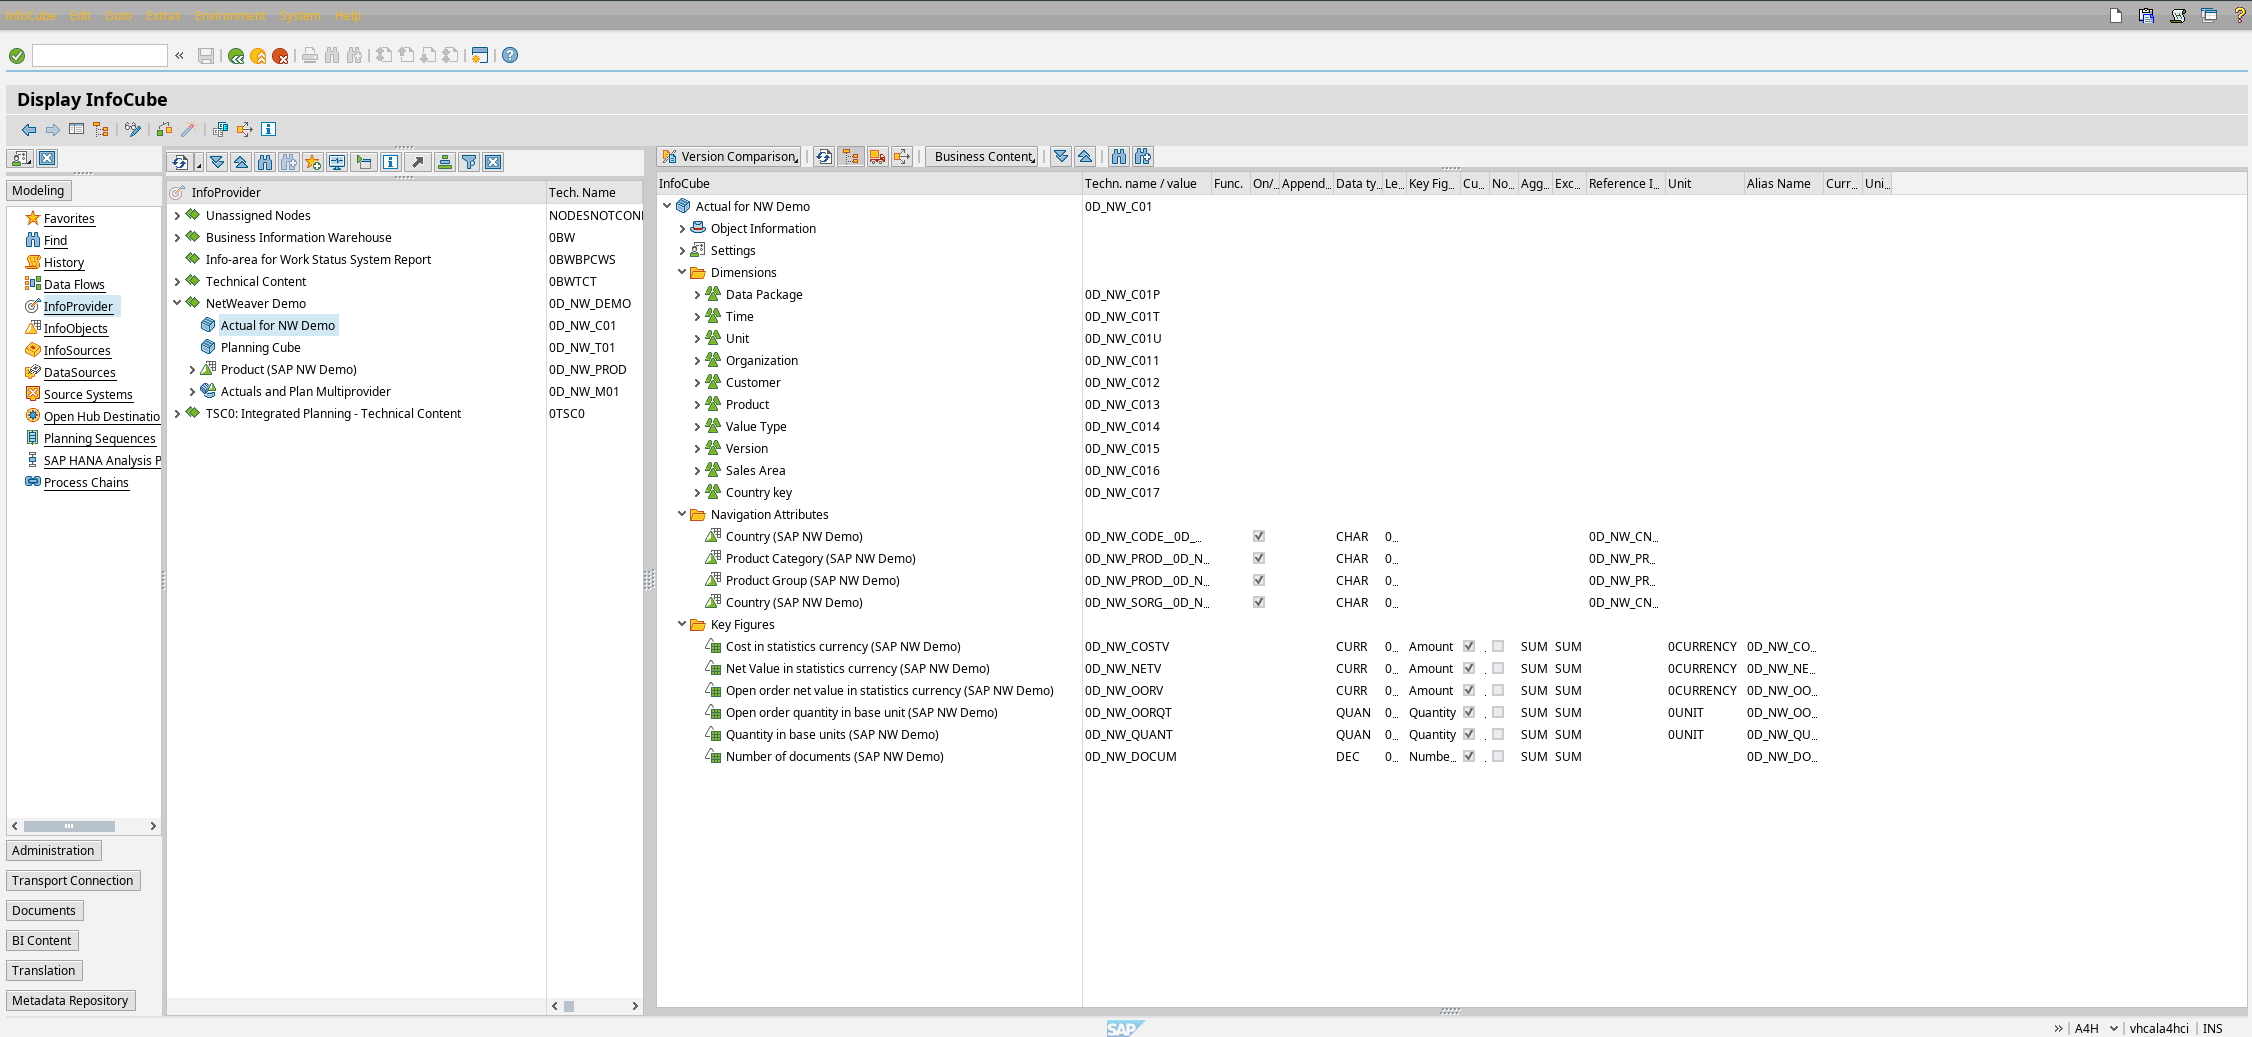

We will query the cube and join the result with local marketing data. The marketing data is stored in a CSV file. The file contains the product ID and the marketing budget for the product.

## Import DuckDB & load **ERPL** extension
In the next cells we import duckdb. Then we install the ERPL extension and load it into the current DB-session. Via multiple SET-commands we configure the connection to our SAP development system. In our case we use the docker based [ABAP Platform Trial](https://hub.docker.com/r/sapse/abap-platform-trial). The credentials are set by default, details can be found in the documentation of the docker image. 

In [1]:
import duckdb

In [2]:
con = duckdb.connect(config={"allow_unsigned_extensions": "true"})
con.install_extension("./erpl.duckdb_extension");
con.load_extension("erpl");
con.sql("""
SET sap_ashost = 'localhost';
SET sap_sysnr = '00';
SET sap_user = 'DEVELOPER';
SET sap_password = 'Htods70334';
SET sap_client = '001';
SET sap_lang = 'EN';
""");

-- Loading ERPL Trampoline Extension. --
(The purpose of the extension is to extract dependencies and load the ERPL implementation)
Saving ERPL SAP dependencies to '/home/jr/.duckdb/extensions/v0.9.2/linux_amd64' and loading them ... done
ERPL extension extracted and saved to /home/jr/.duckdb/extensions/v0.9.2/linux_amd64.
ERPL implementation extension installed from /home/jr/.duckdb/extensions/v0.9.2/linux_amd64/erpl_rfc.duckdb_extension.
ERPL implementation extension loaded. For instructions how to use it visit https://erpl.io


In [3]:
con.sql("PRAGMA sap_rfc_ping")

┌─────────┐
│   msg   │
│ varchar │
├─────────┤
│ PONG    │
└─────────┘

If the loading of the extension was successful, we can find the exportet functions in the list of `duckdb_functions()`

In [4]:
con.sql("SELECT * FROM duckdb_functions() WHERE function_name LIKE '%sap_bics%';")

┌───────────────┬─────────────┬──────────────────────┬───────────────┬───┬──────────┬──────────────┬─────────┐
│ database_name │ schema_name │    function_name     │ function_type │ … │ internal │ function_oid │ example │
│    varchar    │   varchar   │       varchar        │    varchar    │   │ boolean  │    int64     │ varchar │
├───────────────┼─────────────┼──────────────────────┼───────────────┼───┼──────────┼──────────────┼─────────┤
│ system        │ main        │ sap_bics_show_quer…  │ table         │ … │ true     │         1434 │ NULL    │
│ system        │ main        │ sap_bics_show        │ table         │ … │ true     │         1430 │ NULL    │
│ system        │ main        │ sap_bics_show_cubes  │ table         │ … │ true     │         1432 │ NULL    │
│ system        │ main        │ sap_bics_describe    │ table         │ … │ true     │         1436 │ NULL    │
│ system        │ main        │ sap_bics_describe    │ table         │ … │ true     │         1436 │ NULL    │
│

## Explore the schema of the relevant queries

The ERPL extension provides the method `sap_bics_show` to find the relevant [InfoProviders](https://help.sap.com/saphelp_aii710/helpdata/en/4d/c3cd3a9ac2cc6ce10000000a114084/content.htm?no_cache=true), [cubes](https://help.sap.com/saphelp_aii710/helpdata/en/8d/2b4e3cb7f4d83ee10000000a114084/content.htm?no_cache=true) or queries.

In [5]:
con.sql("SELECT * FROM sap_bics_show(SEARCH='*NW Demo*', OBJ_TYPE='CUBE');")

┌────────────────┬────────────────────┬─────────┐
│ technical_name │        text        │  type   │
│    varchar     │      varchar       │ varchar │
├────────────────┼────────────────────┼─────────┤
│ 0D_NW_C01      │ Actual for NW Demo │ CUBE    │
└────────────────┴────────────────────┴─────────┘

In [6]:
con.sql("""
SELECT unnest(characteristics, recursive:=true) as ch_name FROM sap_bics_describe('0D_NW_C01');
""")

┌──────────────────────┬──────────────────────┬───┬──────────────────────┬──────────────────────┬───────────┐
│         text         │    technical_name    │ … │      attributes      │      structures      │ elements  │
│       varchar        │       varchar        │   │ struct("text" varc…  │ struct("text" varc…  │ varchar[] │
├──────────────────────┼──────────────────────┼───┼──────────────────────┼──────────────────────┼───────────┤
│ Unit of Measure      │ 0UNIT                │ … │ []                   │ []                   │ []        │
│ Value Type for Rep   │ 0D_NW_VTYPE          │ … │ []                   │ []                   │ []        │
│ Version              │ 0D_NW_VERS           │ … │ []                   │ []                   │ []        │
│ Country              │ 0D_NW_SORG__0D_NW_…  │ … │ []                   │ []                   │ []        │
│ Sales Organization   │ 0D_NW_SORG           │ … │ [{'text': Country,…  │ []                   │ []        │
│ Sold-to 

In [8]:
con.sql("SELECT * FROM sap_bics_begin('0D_NW_C01', ID='q1', RETURN='RESULT')")

┌─────────────┬─────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ 0D_NW_COSTV │ 0D_NW_DOCUM │  0D_NW_NETV  │ 0D_NW_OORQT │ 0D_NW_OORV  │ 0D_NW_QUANT │
│   double    │   double    │    double    │   double    │   double    │   double    │
├─────────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┤
│         0.0 │      7128.0 │ 4674811295.0 │     14256.0 │ 607725822.0 │      7108.0 │
└─────────────┴─────────────┴──────────────┴─────────────┴─────────────┴─────────────┘

In [9]:
con.sql("SELECT state_id, state_version, state_rows FROM sap_bics_describe(ID='q1', VERSION=1)")

┌──────────┬───────────────┬──────────────────────────────────────────────────────────────────────┐
│ state_id │ state_version │                              state_rows                              │
│ varchar  │    uint32     │           struct("text" varchar, technical_name varchar)[]           │
├──────────┼───────────────┼──────────────────────────────────────────────────────────────────────┤
│ q1       │             1 │ [{'text': Key Figures, 'technical_name': 0MEASURES0000000000000009}] │
└──────────┴───────────────┴──────────────────────────────────────────────────────────────────────┘

In [11]:
con.sql("SELECT * FROM sap_bics_rows('q1', '0CALMONTH', OP='ADD', RETURN='RESULT');")

┌───────────┬─────────────┬─────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ 0CALMONTH │ 0D_NW_COSTV │ 0D_NW_DOCUM │  0D_NW_NETV  │ 0D_NW_OORQT │ 0D_NW_OORV  │ 0D_NW_QUANT │
│  varchar  │   double    │   double    │    double    │   double    │   double    │   double    │
├───────────┼─────────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┤
│ 201001    │         0.0 │        54.0 │   27894479.0 │       108.0 │   3626286.0 │        54.0 │
│ 201002    │         0.0 │        54.0 │   38343037.0 │       108.0 │   4984600.0 │        54.0 │
│ 201003    │         0.0 │        54.0 │   38410540.0 │       108.0 │   4993374.0 │        54.0 │
│ 201004    │         0.0 │        54.0 │   40079485.0 │       108.0 │   5210338.0 │        54.0 │
│ 201005    │         0.0 │        54.0 │   32379708.0 │       108.0 │   4209363.0 │        54.0 │
│ 201006    │         0.0 │        54.0 │   34721026.0 │       108.0 │   4513737.0 │        54.0 │
│ 201007  

In [12]:
con.sql("SELECT * FROM sap_bics_rows('q1', '0D_NW_REGIO', OP='ADD', RETURN='RESULT');")

┌───────────┬─────────────┬─────────────┬─────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ 0CALMONTH │ 0D_NW_REGIO │ 0D_NW_COSTV │ 0D_NW_DOCUM │  0D_NW_NETV  │ 0D_NW_OORQT │ 0D_NW_OORV  │ 0D_NW_QUANT │
│  varchar  │   varchar   │   double    │   double    │    double    │   double    │   double    │   double    │
├───────────┼─────────────┼─────────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┤
│ 201001    │ DE 11       │         0.0 │        12.0 │    5994415.0 │        24.0 │    779275.0 │        12.0 │
│ 201001    │ FR 75       │         0.0 │        12.0 │    8144894.0 │        24.0 │   1058837.0 │        12.0 │
│ 201001    │ GB LO       │         0.0 │         6.0 │    2585619.0 │        12.0 │    336130.0 │         6.0 │
│ 201001    │ US CA       │         0.0 │        12.0 │    5000781.0 │        24.0 │    650103.0 │        12.0 │
│ 201001    │ US NY       │         0.0 │        12.0 │    6168770.0 │        24.0 │    801941.0

In [13]:
con.sql("SELECT * FROM sap_bics_result('q1')")

┌───────────┬─────────────┬─────────────┬─────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ 0CALMONTH │ 0D_NW_REGIO │ 0D_NW_COSTV │ 0D_NW_DOCUM │  0D_NW_NETV  │ 0D_NW_OORQT │ 0D_NW_OORV  │ 0D_NW_QUANT │
│  varchar  │   varchar   │   double    │   double    │    double    │   double    │   double    │   double    │
├───────────┼─────────────┼─────────────┼─────────────┼──────────────┼─────────────┼─────────────┼─────────────┤
│ 201001    │ DE 11       │         0.0 │        12.0 │    5994415.0 │        24.0 │    779275.0 │        12.0 │
│ 201001    │ FR 75       │         0.0 │        12.0 │    8144894.0 │        24.0 │   1058837.0 │        12.0 │
│ 201001    │ GB LO       │         0.0 │         6.0 │    2585619.0 │        12.0 │    336130.0 │         6.0 │
│ 201001    │ US CA       │         0.0 │        12.0 │    5000781.0 │        24.0 │    650103.0 │        12.0 │
│ 201001    │ US NY       │         0.0 │        12.0 │    6168770.0 │        24.0 │    801941.0